# Final Project: Experiments 3 and 4

In [1]:
from torch.nn import Module
from torch import nn

import numpy as np
import os
import torch
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Additional imports
import time
import matplotlib.pyplot as plt

In [2]:
def train_experiment_4(model):
    start_time = time.time()
    
    batch_size = 256
    train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor())
    test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor())
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    sgd = SGD(model.parameters(), lr=1e-1)
    loss_fn = CrossEntropyLoss()
    all_epoch = 100
    prev_acc = 0
    for current_epoch in range(all_epoch):
        model.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            sgd.zero_grad()
            predict_y = model(train_x.float())
            loss = loss_fn(predict_y, train_label.long())
            loss.backward()
            sgd.step()

        all_correct_num = 0
        all_sample_num = 0
        model.eval()

        for idx, (test_x, test_label) in enumerate(test_loader):
            predict_y = model(test_x.float()).detach()
            predict_y =torch.argmax(predict_y, dim=-1)
            current_correct_num = predict_y == test_label
            all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
            all_sample_num += current_correct_num.shape[0]
        acc = all_correct_num / all_sample_num
#         print('accuracy: {:.3f}'.format(acc), flush=True)
        if not os.path.isdir("models"):
            os.mkdir("models")
        torch.save(model, 'models/mnist_{:.3f}.pkl'.format(acc))
        if np.abs(acc - prev_acc) < 1e-4:
            break
        prev_acc = acc
#     print("Model finished training")
    return acc, time.time() - start_time

## Experiment 3: Maxpool Tweaks

### Define Model

In [14]:
class LeNet3(Module):
    def __init__(self, kernel_size, stride, padding):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=padding)
        self.fc1 = nn.LazyLinear(120) 
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

### Train Model

In [19]:
# Default 
model1 = LeNet3(2, 2, 0)
acc1, time1 = train_experiment_4(model1)
print("Model 1 Accuracy:", acc1, "Time:", time1)

# Increase kernel size
model2 = LeNet3(3, 3, 0)
acc2, time2 = train_experiment_4(model2)
print("Model 2 Accuracy:", acc2, "Time:", time2)

# Increase stride
model3 = LeNet3(2, 3, 0)
acc3, time3 = train_experiment_4(model3)
print("Model 3 Accuracy:", acc3, "Time:", time3)

# Add padding
model4 = LeNet3(2, 3, 1)
acc4, time4 = train_experiment_4(model4)
print("Model 4 Accuracy:", acc4, "Time:", time4)

# Decrease stride
model5 = LeNet3(2, 1, 0)
acc5, time5 = train_experiment_4(model5)
print("Model 5 Accuracy:", acc5, "Time:", time5)

# Increase kernel size, decrease stride
model6 = LeNet3(3, 1, 0)
acc6, time6 = train_experiment_4(model6)
print("Model 6 Accuracy:", acc6, "Time:", time6)

# Increase kernel size, increase stride, add padding
model7 = LeNet3(3, 4, 1)
acc7, time7 = train_experiment_4(model7)
print("Model 7 Accuracy:", acc7, "Time:", time7)

Model 1 Accuracy: 0.979 Time: 213.00752782821655
Model 2 Accuracy: 0.795 Time: 165.3505392074585
Model 3 Accuracy: 0.9686 Time: 256.6614339351654
Model 4 Accuracy: 0.7885 Time: 227.20667815208435
Model 5 Accuracy: 0.6984 Time: 178.35092616081238
Model 2 Accuracy: 0.9715 Time: 695.8001260757446
Model 7 Accuracy: 0.9772 Time: 232.69445204734802


## Experiment 4: Deepen the Model
### Define Models

In [4]:
# 1 Convolutional Layer
class LeNet4a(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(864, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

# 2 Convolutional Layers (Original Model)
class LeNet4b(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120) 
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y
    
# 3 Convolutional Layers
class LeNet4c(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, 3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)
        self.fc1 = nn.LazyLinear(120) 
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = self.conv3(y)
        y = self.relu3(y)
        y = self.pool3(y) 
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

# 4 Convolutional Layers
class LeNet4d(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, 3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)
        self.conv4 = nn.Conv2d(16, 16, 3)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)
        self.fc1 = nn.LazyLinear(120) 
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = self.conv3(y)
        y = self.relu3(y)
        y = self.pool3(y) 
        y = self.conv4(y)
        y = self.relu4(y)
        y = self.pool4(y) 
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

### Train Models

In [5]:
model1 = LeNet4a()
acc1, time1 = train_experiment_4(model1)
print("Model 1 Accuracy:", acc1, "Time:", time1)

model2 = LeNet4b()
acc2, time2 = train_experiment_4(model2)
print("Model 2 Accuracy:", acc2, "Time:", time2)

model3 = LeNet4c()
acc3, time3 = train_experiment_4(model3)
print("Model 3 Accuracy:", acc3, "Time:", time3)

model4 = LeNet4d()
acc4, time4 = train_experiment_4(model4)
print("Model 4 Accuracy:", acc4, "Time:", time4)

Model 1 Accuracy: 0.9764 Time: 131.668475151062
Model 2 Accuracy: 0.9781 Time: 188.7756369113922


/Users/angelalandry/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Model 3 Accuracy: 0.7946 Time: 566.3674829006195
Model 4 Accuracy: 0.8796 Time: 931.2274339199066


### Visualize Results

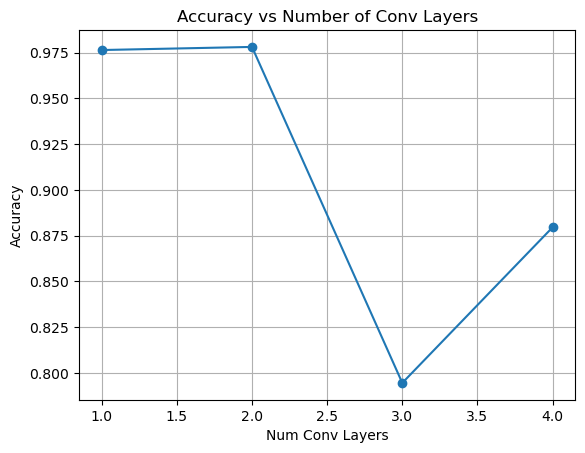

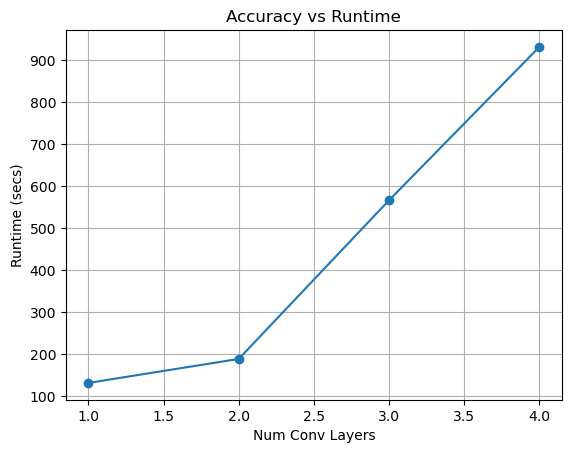

In [8]:
conv_layers = [1, 2, 3, 4]
accuracies = [acc1, acc2, acc3, acc4]
times = [time1, time2, time3, time4]

plt.plot(conv_layers, accuracies, 'o-')
plt.xlabel('Num Conv Layers')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Conv Layers')
plt.grid(True)
plt.show();

plt.plot(conv_layers, times, 'o-')
plt.xlabel('Num Conv Layers')
plt.ylabel('Runtime (secs)')
plt.title('Accuracy vs Runtime')
plt.grid(True)
plt.show();